# Channel viewer

In [ ]:
#| default_exp repr_chans

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq, is_close
from matplotlib import pyplot as plt
from lovely_tensors import monkey_patch

In [ ]:
# |hide
monkey_patch()

In [ ]:
# |hide
# |export
from matplotlib import colormaps
from matplotlib.colors import to_rgba, ListedColormap
import torch

In [ ]:
# |export
from lovely_tensors.repr_rgb import RGBProxy
from lovely_tensors.colormap import TorchCmap
from lovely_tensors.pad import pad_frame_gutters
from lovely_tensors.tile2d import tile_images

In [ ]:
# |exporti
def _chans(t: torch.Tensor, # 2 or 3-dim tensor to view. Channel-first if 3d.
                 cmap = "coolwarm", # Use matplotlib colormap by this name
                 cm_below="blue", cm_above="red",
                 cm_ninf="cyan", cm_pinf="fuchsia",
                 cm_nan="yellow",
                 view_width=966,
                 pad_frac=0.05,   # Draw write gutters when tiling the images
                 frame_px=1):     # Draw black frame around each image
    
    """
    Process individual channels of a tensor that can be interpreted as as image
    `x` and `y` specify which dimensions should be used as spatial ones.
    """
    
    assert t.dim() in (2, 3), f"Expected a 2 or 3-dim input, got {t.shape}={t.dim()}"
    if t.dim() == 2: t = t.expand(0)
    
    
    ### XXX Do we want a way to pass a custom cmap instead of mpl one?
    tcmap = TorchCmap(cmap=colormaps[cmap],
                  below=cm_below, above=cm_above,
                  nan=cm_nan, ninf=cm_ninf, pinf=cm_pinf)

    padded = pad_frame_gutters(tcmap(t), gutter_frac=pad_frac, frame_px=frame_px)
    tiled = tile_images(padded, view_width=view_width)  
    
#     return tiled
    return RGBProxy(tiled)(cl=True)

In [ ]:
# |exporti
class ChanProxy():
    def __init__(self, t: torch.Tensor):
        self.t = t
    
    def __call__(self,
                 cmap = "coolwarm", # Use matplotlib colormap by this name
                 cm_below="blue",   # Override color for values velow 0
                 cm_above="red",    # Override color for values above 1
                 cm_ninf="cyan",    # Override color for -inf values
                 cm_pinf="fuchsia", # Override color for +inf values
                 cm_nan="yellow",   # Override color for NaN values
                 view_width=966,    # Try to produce an image at most this wide
                 pad_frac=0.05,     # Draw write gutters when tiling the images, %of the image.
                 frame_px=1 ):      # Drawa black frame around images.
        
        return _chans(self.t,
                     cmap=cmap,
                     cm_below=cm_below,
                     cm_above=cm_above,
                     cm_ninf=cm_ninf,
                     cm_pinf=cm_pinf,
                     cm_nan=cm_nan,
                     view_width=view_width,
                     pad_frac=pad_frac,
                     frame_px=frame_px)
    
    def _repr_png_(self):
        return self.__call__()._repr_png_()

In [ ]:
# |export
def chans(t: torch.Tensor, # 2 or 3-dim tensor to view. Channel-first if 3d.
             cmap = "coolwarm", # Use matplotlib colormap by this name
             cm_below="blue", cm_above="red",
             cm_ninf="cyan", cm_pinf="fuchsia",
             cm_nan="yellow",
             view_width=966,
             pad_frac=0.05,   # Draw write gutters when tiling the images
             frame_px=1):     # Draw black frame around each image
    
    return ChanProxy(t)(cmap=cmap,
                         cm_below=cm_below,
                         cm_above=cm_above,
                         cm_ninf=cm_ninf,
                         cm_pinf=cm_pinf,
                         cm_nan=cm_nan,
                         view_width=view_width,
                         pad_frac=pad_frac,
                         frame_px=frame_px)

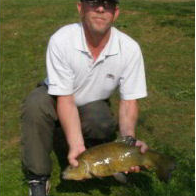

In [ ]:
in_stats = { "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225) }

image = torch.load("mysteryman.pt")
image = (image * torch.tensor(in_stats["std"])[:,None,None])
image += torch.tensor(in_stats["mean"])[:,None,None]

image.rgb

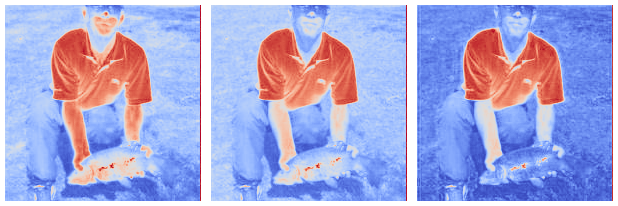

In [ ]:
chans(image)

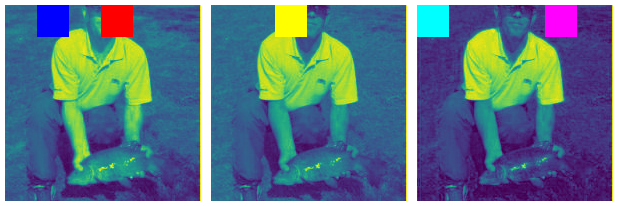

In [ ]:
# In R
image[0,0:32,32:64] = -0.1 # Below min
image[0,0:32,96:128] = 1.1 # Above max
# In G
image[1,0:32,64:96] = float("nan")
# In B
image[2,0:32,0:32] = float("-inf")
image[2,0:32,128:128+32] = float("+inf")

chans(image, cmap="viridis")

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()